In [1]:
import sys
sys.path.append('../utils')
import warnings
warnings.filterwarnings('ignore')

import os
import time 
import copy 
import re

from sklearn import datasets
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np 

import model_functions
import model_utils
import plotting_utils
import scoring_utils

In [2]:
internet_data_dir = '../data/internet/'
ndhs_data_dir = '../data/ndhs/'
ntl_data_dir = '../data/nightlights/'

dhs_indicators_path = ndhs_data_dir + 'dhs_indicators.csv'
ntl_summary_stats_path = ntl_data_dir + 'nightlights_summary_stats.csv'

fixed_dlspeed_summary_stats_path = internet_data_dir + 'summary_stats/imputed_fixed download_speeds_summary_stats.csv'
fixed_ulspeed_summary_stats_path = internet_data_dir + 'summary_stats/imputed_fixed upload_speeds_summary_stats.csv'
fixed_latency_summary_stats_path = internet_data_dir + 'summary_stats/imputed_fixed latency_summary_stats.csv'
mobile_dlspeed_summary_stats_path = internet_data_dir + 'summary_stats/imputed_mobile download_speeds_summary_stats.csv'
mobile_ulspeed_summary_stats_path = internet_data_dir + 'summary_stats/imputed_mobile upload_speeds_summary_stats.csv'
mobile_latency_summary_stats_path = internet_data_dir + 'summary_stats/imputed_mobile latency_summary_stats.csv'

In [3]:
osm_roads_file = '../data/osm/osm_roads.csv'
osm_buildings_file = '../data/osm/osm_buildings.csv'
osm_pois_file = '../data/osm/osm_pois.csv'

roads = pd.read_csv(osm_roads_file)
buildings = pd.read_csv(osm_buildings_file)
pois = pd.read_csv(osm_pois_file)

road_cols = roads.columns[1:]
building_cols = buildings.columns[1:]
poi_cols = pois.columns[1:]

osm_cols = list(road_cols) + list(building_cols) + list(poi_cols)

osm = roads.merge(buildings, on='DHSCLUST')
osm = osm.merge(pois, on='DHSCLUST')

In [4]:
fixed_dlspeed_summary_stats = pd.read_csv(fixed_dlspeed_summary_stats_path).drop('Unnamed: 0', 1)
fixed_ulspeed_summary_stats = pd.read_csv(fixed_ulspeed_summary_stats_path).drop('Unnamed: 0', 1)
fixed_latency_summary_stats = pd.read_csv(fixed_latency_summary_stats_path).drop('Unnamed: 0', 1)
mobile_dlspeed_summary_stats = pd.read_csv(mobile_dlspeed_summary_stats_path).drop('Unnamed: 0', 1)
mobile_ulspeed_summary_stats = pd.read_csv(mobile_ulspeed_summary_stats_path).drop('Unnamed: 0', 1)
mobile_latency_summary_stats = pd.read_csv(mobile_latency_summary_stats_path).drop('Unnamed: 0', 1)
ntl_summary_stats = pd.read_csv(ntl_summary_stats_path)

dhs_indicators = pd.read_csv(dhs_indicators_path)
dlspeeds = fixed_dlspeed_summary_stats.merge(dhs_indicators, left_on='DHS Cluster Number', right_on='cluster_number')
ulspeeds = fixed_ulspeed_summary_stats.merge(dhs_indicators, left_on='DHS Cluster Number', right_on='cluster_number')
latency = fixed_latency_summary_stats.merge(dhs_indicators, left_on='DHS Cluster Number', right_on='cluster_number')


# Define feature columns
ntl_summary_stats.columns = ['DHSCLUST', 'ntl_cov', 'ntl_kurtosis', 'ntl_max', 'ntl_mean', 'ntl_median','ntl_min', 'ntl_skewness', 'ntl_std']
feature_cols_fixed_dl = ['fixed_dl_Mean', 'fixed_dl_Maximum', 'fixed_dl_Minimum', 'fixed_dl_Standard Deviation', 'fixed_dl_Median', 'fixed_dl_Skew', 'fixed_dl_Coefficient of Variation', 'fixed_dl_Kurtosis']
feature_cols_fixed_ul = ['fixed_ul_Mean', 'fixed_ul_Maximum', 'fixed_ul_Minimum', 'fixed_ul_Standard Deviation', 'fixed_ul_Median', 'fixed_ul_Skew', 'fixed_ul_Coefficient of Variation', 'fixed_ul_Kurtosis']
feature_cols_fixed_lat = ['fixed_lat_Mean', 'fixed_lat_Maximum', 'fixed_lat_Minimum', 'fixed_lat_Standard Deviation', 'fixed_lat_Median', 'fixed_lat_Skew', 'fixed_lat_Coefficient of Variation', 'fixed_lat_Kurtosis']
feature_cols_mobile_dl = ['mobile_dl_Mean', 'mobile_dl_Maximum', 'mobile_dl_Minimum', 'mobile_dl_Standard Deviation', 'mobile_dl_Median', 'mobile_dl_Skew', 'mobile_dl_Coefficient of Variation', 'mobile_dl_Kurtosis']
feature_cols_mobile_ul = ['mobile_ul_Mean', 'mobile_ul_Maximum', 'mobile_ul_Minimum', 'mobile_ul_Standard Deviation', 'mobile_ul_Median', 'mobile_ul_Skew', 'mobile_ul_Coefficient of Variation', 'mobile_ul_Kurtosis']
feature_cols_mobile_lat = ['mobile_lat_Mean', 'mobile_lat_Maximum', 'mobile_lat_Minimum', 'mobile_lat_Standard Deviation', 'mobile_lat_Median', 'mobile_lat_Skew', 'mobile_lat_Coefficient of Variation', 'mobile_lat_Kurtosis']
feature_cols_nightlights = ['ntl_cov', 'ntl_kurtosis', 'ntl_max', 'ntl_mean', 'ntl_median','ntl_min', 'ntl_skewness', 'ntl_std']
feature_cols_FINAL = feature_cols_fixed_dl + feature_cols_fixed_ul + feature_cols_fixed_lat + feature_cols_mobile_dl + feature_cols_mobile_ul + feature_cols_mobile_lat + feature_cols_nightlights + osm_cols


In [5]:
data = fixed_dlspeed_summary_stats.merge(dhs_indicators, left_on='DHS Cluster Number', right_on='cluster_number')\
        .merge(fixed_ulspeed_summary_stats, on='DHS Cluster Number')\
        .merge(fixed_latency_summary_stats, on='DHS Cluster Number')\
        .merge(mobile_dlspeed_summary_stats, on='DHS Cluster Number')\
        .merge(mobile_ulspeed_summary_stats, on='DHS Cluster Number')\
        .merge(mobile_latency_summary_stats, on='DHS Cluster Number')\
        .merge(osm, left_on='DHS Cluster Number', right_on='DHSCLUST')\
        .merge(ntl_summary_stats, left_on='DHS Cluster Number', right_on='DHSCLUST')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   24.3s remaining:   16.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   25.9s remaining:   17.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.2s finished


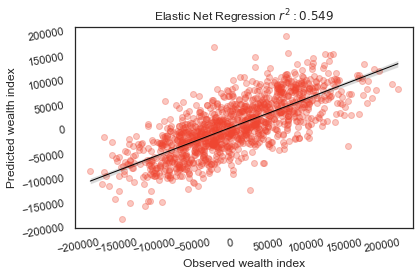

In [39]:
X = data[feature_cols_mobile_lat]
y = data['wealth_index']

model_type = 'elastic_net'

model = model_utils.get_model(model_type)
param_grid = model_utils.get_param_grid(model_type)
cv, nested_scores, y, y_pred = model_utils.nested_cross_validation(model, X, y, param_grid, n_iter=300000, verbose=2)
model_utils.plot_cross_val_results(y, y_pred, 'Elastic Net Regression', nested_scores, 'Ridge Regression ')

In [7]:
cv.fit(X, y)
print('Best Estimator: {}'.format(cv.best_estimator_))
model_utils.random_forest_feature_importance(cv, X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Estimator: Pipeline(steps=[('regressor',
                 Lasso(alpha=3.8028572256396647, normalize=False,
                       random_state=42))])


AttributeError: 'Lasso' object has no attribute 'feature_importances_'

In [ ]:
model_utils.plot_cross_val_results(y, y_pred, 'Wealth Index', nested_scores)

In [ ]:
X = data[feature_cols_FINAL]
y = data['wealth_index']

model = model_utils.get_model('random_forest')
param_grid = model_utils.get_param_grid('random_forest')
cv, nested_scores, y, y_pred = model_utils.nested_cross_validation(model, X, y, param_grid, n_iter=5, verbose=2)

cv.fit(X, y)
print('Best Estimator: {}'.format(cv.best_estimator_))
model_utils.random_forest_feature_importance(cv, X, y)

model_utils.plot_cross_val_results(y, y_pred, 'Wealth Index', nested_scores)